In [41]:
# ===============================================================
# 03_train_generator_part1.ipynb
# Deep ResNet-βVAE for Medical Image Generation
# ===============================================================

import os, math, random
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils as vutils

# ---------- setup ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print("✅ Device:", DEVICE)

# ---------- dataset ----------
class XrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = [str(Path(root_dir)/f) for f in os.listdir(root_dir)
                      if f.lower().endswith(('.png','.jpg','.jpeg'))]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        im = Image.open(self.paths[idx]).convert("L")
        return self.transform(im) if self.transform else im

IMG_SIZE = 128
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dir = "../Data/train"
ds = XrayDataset(train_dir, tfm)
dl = DataLoader(ds, batch_size=32, shuffle=True, num_workers=0)
print("✅ Training images:", len(ds))

# ---------- resnet blocks ----------
class ResBlock(nn.Module):
    def __init__(self, c_in, c_out, down=False, up=False):
        super().__init__()
        self.down, self.up = down, up
        stride = 2 if down else 1
        self.conv1 = nn.Conv2d(c_in, c_out, 3, stride=stride, padding=1)
        self.gn1 = nn.GroupNorm(8, c_out)
        self.conv2 = nn.Conv2d(c_out, c_out, 3, padding=1)
        self.gn2 = nn.GroupNorm(8, c_out)
        self.act = nn.SiLU(inplace=True)
        self.skip = nn.Conv2d(c_in, c_out, 1, stride=stride) if (c_in!=c_out or down) else nn.Identity()
        if up: self.up2 = nn.Upsample(scale_factor=2, mode="nearest")
    def forward(self, x):
        if self.up: x = self.up2(x)
        h = self.act(self.gn1(self.conv1(x)))
        h = self.gn2(self.conv2(h))
        return self.act(h + self.skip(x))

# ---------- VAE ----------
class ResVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        ch = [32, 64, 128, 256, 512]
        self.enc_in = nn.Conv2d(1, ch[0], 3, padding=1)
        self.e1 = ResBlock(ch[0], ch[0])
        self.e2 = ResBlock(ch[0], ch[1], down=True)
        self.e3 = ResBlock(ch[1], ch[2], down=True)
        self.e4 = ResBlock(ch[2], ch[3], down=True)
        self.e5 = ResBlock(ch[3], ch[4], down=True)
        
        # ✅ Fix flatten dimension (for 128×128 input)
        self.flatten_dim = ch[4] * (IMG_SIZE // 16) ** 2
        
        self.mu = nn.Linear(self.flatten_dim, latent_dim)
        self.logvar = nn.Linear(self.flatten_dim, latent_dim)
        self.fc = nn.Linear(latent_dim, self.flatten_dim)
        
        self.d5 = ResBlock(ch[4], ch[3], up=True)
        self.d4 = ResBlock(ch[3], ch[2], up=True)
        self.d3 = ResBlock(ch[2], ch[1], up=True)
        self.d2 = ResBlock(ch[1], ch[0], up=True)
        self.d1 = ResBlock(ch[0], ch[0])
        self.dec_out = nn.Conv2d(ch[0], 1, 3, padding=1)
    def encode(self, x):
        x = self.enc_in(x); x = self.e1(x); x = self.e2(x); x = self.e3(x); x = self.e4(x); x = self.e5(x)
        x = x.view(x.size(0), -1)
        return self.mu(x), self.logvar(x)
    def reparameterize(self, mu, logvar):
        std, eps = torch.exp(0.5*logvar), torch.randn_like(logvar)
        return mu + eps*std
    def decode(self, z):
        h = self.fc(z).view(z.size(0), 512, IMG_SIZE//16, IMG_SIZE//16)
        h = self.d5(h)
        h = self.d4(h)
        h = self.d3(h)
        h = self.d2(h)
        h = self.d1(h)
        return torch.tanh(self.dec_out(h))
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        xr = self.decode(z)
        return xr, mu, logvar

# ---------- loss ----------
def recon_loss(xr, x):
    l1 = F.l1_loss(xr, x, reduction="mean")
    l2 = F.mse_loss(xr, x, reduction="mean")
    return 0.85*l1 + 0.15*l2
def kld(mu, logvar):
    return -0.5*torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
def vae_total_loss(xr, x, mu, logvar, beta):
    return recon_loss(xr, x) + beta*kld(mu, logvar)

# ---------- training ----------
model = ResVAE(latent_dim=128).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=30)
EPOCHS = 30; max_beta = 1.0
os.makedirs("../Model", exist_ok=True)

for epoch in range(1, EPOCHS+1):
    model.train(); beta = min(max_beta, max_beta*(epoch/(EPOCHS*0.4)))
    losses=[]
    for x in dl:
        x=x.to(DEVICE)
        xr,mu,logvar=model(x)
        loss=vae_total_loss(xr,x,mu,logvar,beta)
        opt.zero_grad(set_to_none=True); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),1.0)
        opt.step(); losses.append(loss.item())
    sched.step()
    print(f"Epoch {epoch:02d}/{EPOCHS} | β={beta:.3f} | Loss={np.mean(losses):.4f}")
    torch.save(model.state_dict(),"../Model/vae_resnet_latest.pt")

print("✅ Training complete.")

✅ Device: cpu
✅ Training images: 1000
Epoch 01/30 | β=0.083 | Loss=0.2414
Epoch 02/30 | β=0.167 | Loss=0.1914
Epoch 03/30 | β=0.250 | Loss=0.1870
Epoch 04/30 | β=0.333 | Loss=0.1855
Epoch 05/30 | β=0.417 | Loss=0.1911
Epoch 06/30 | β=0.500 | Loss=0.1905
Epoch 07/30 | β=0.583 | Loss=0.1897
Epoch 08/30 | β=0.667 | Loss=0.1886
Epoch 09/30 | β=0.750 | Loss=0.1917
Epoch 10/30 | β=0.833 | Loss=0.1900
Epoch 11/30 | β=0.917 | Loss=0.1887
Epoch 12/30 | β=1.000 | Loss=0.1899
Epoch 13/30 | β=1.000 | Loss=0.1900
Epoch 14/30 | β=1.000 | Loss=0.1872
Epoch 15/30 | β=1.000 | Loss=0.1878
Epoch 16/30 | β=1.000 | Loss=0.1867
Epoch 17/30 | β=1.000 | Loss=0.1866
Epoch 18/30 | β=1.000 | Loss=0.1852
Epoch 19/30 | β=1.000 | Loss=0.1846
Epoch 20/30 | β=1.000 | Loss=0.1841
Epoch 21/30 | β=1.000 | Loss=0.1845
Epoch 22/30 | β=1.000 | Loss=0.1841
Epoch 23/30 | β=1.000 | Loss=0.1831
Epoch 24/30 | β=1.000 | Loss=0.1819
Epoch 25/30 | β=1.000 | Loss=0.1821
Epoch 26/30 | β=1.000 | Loss=0.1808
Epoch 27/30 | β=1.000 | Lo

In [43]:
# ===============================================================
# 03_train_generator_part1_upgraded.ipynb
# ResNet β-VAE + PatchGAN (VAE-GAN) for sharper medical synthesis
# ===============================================================

import os, math, random
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ---------- setup ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print("✅ Device:", DEVICE)

# ---------- dataset ----------
class XrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = [str(Path(root_dir)/f) for f in os.listdir(root_dir)
                      if f.lower().endswith(('.png','.jpg','.jpeg'))]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        im = Image.open(self.paths[idx]).convert("L")
        return self.transform(im) if self.transform else im

IMG_SIZE = 128  # you can try 192 or 256 later for more detail
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # to [-1,1]
])

train_dir = "../Data/train"
ds = XrayDataset(train_dir, tfm)
dl = DataLoader(ds, batch_size=32, shuffle=True, num_workers=0)
print("✅ Training images:", len(ds))

# ---------- ResNet blocks ----------
class ResBlock(nn.Module):
    def __init__(self, c_in, c_out, down=False, up=False):
        super().__init__()
        self.down, self.up = down, up
        stride = 2 if down else 1
        self.conv1 = nn.Conv2d(c_in, c_out, 3, stride=stride, padding=1)
        self.gn1 = nn.GroupNorm(8, c_out)
        self.conv2 = nn.Conv2d(c_out, c_out, 3, padding=1)
        self.gn2 = nn.GroupNorm(8, c_out)
        self.act = nn.SiLU(inplace=True)
        self.skip = nn.Conv2d(c_in, c_out, 1, stride=stride) if (c_in!=c_out or down) else nn.Identity()
        if up: self.up2 = nn.Upsample(scale_factor=2, mode="nearest")
    def forward(self, x):
        if self.up: x = self.up2(x)
        h = self.act(self.gn1(self.conv1(x)))
        h = self.gn2(self.conv2(h))
        return self.act(h + self.skip(x))

# ---------- β-VAE (encoder/decoder) ----------
class ResVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        ch = [32, 64, 128, 256, 512]
        self.enc_in = nn.Conv2d(1, ch[0], 3, padding=1)
        self.e1 = ResBlock(ch[0], ch[0])
        self.e2 = ResBlock(ch[0], ch[1], down=True)   # 128->64
        self.e3 = ResBlock(ch[1], ch[2], down=True)   # 64->32
        self.e4 = ResBlock(ch[2], ch[3], down=True)   # 32->16
        self.e5 = ResBlock(ch[3], ch[4], down=True)   # 16->8

        # 128 → 8 spatial ⇒ //16
        self.flatten_dim = ch[4] * (IMG_SIZE // 16) ** 2

        self.mu     = nn.Linear(self.flatten_dim, latent_dim)
        self.logvar = nn.Linear(self.flatten_dim, latent_dim)

        self.fc = nn.Linear(latent_dim, self.flatten_dim)
        self.d5 = ResBlock(ch[4], ch[3], up=True)
        self.d4 = ResBlock(ch[3], ch[2], up=True)
        self.d3 = ResBlock(ch[2], ch[1], up=True)
        self.d2 = ResBlock(ch[1], ch[0], up=True)
        self.d1 = ResBlock(ch[0], ch[0])
        self.dec_out = nn.Conv2d(ch[0], 1, 3, padding=1)

    def encode(self, x):
        x = self.enc_in(x); x = self.e1(x); x = self.e2(x); x = self.e3(x); x = self.e4(x); x = self.e5(x)
        x = x.view(x.size(0), -1)
        return self.mu(x), self.logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc(z).view(z.size(0), 512, IMG_SIZE//16, IMG_SIZE//16)  # 8x8
        h = self.d5(h); h = self.d4(h); h = self.d3(h); h = self.d2(h); h = self.d1(h)
        return torch.tanh(self.dec_out(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z  = self.reparameterize(mu, logvar)
        xr = self.decode(z)
        return xr, mu, logvar

# ---------- PatchGAN Discriminator (small & fast) ----------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        # outputs an H/16 × W/16 map of real/fake scores
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,   base,   4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base,    base*2, 4, stride=2, padding=1), nn.GroupNorm(8, base*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base*2,  base*4, 4, stride=2, padding=1), nn.GroupNorm(8, base*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base*4,  base*8, 4, stride=2, padding=1), nn.GroupNorm(8, base*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base*8,  1,      3, padding=1)  # logits
        )
    def forward(self, x): return self.net(x)

# ---------- losses ----------
def recon_loss(xr, x):
    # L1 + small MSE for smoothness
    l1 = F.l1_loss(xr, x, reduction="mean")
    l2 = F.mse_loss(xr, x, reduction="mean")
    return 0.85*l1 + 0.15*l2

def laplacian_edges(x):
    # 3x3 Laplacian kernel (fixed) to emphasize edges
    kernel = torch.tensor([[0.,  1., 0.],
                           [1., -4., 1.],
                           [0.,  1., 0.]], device=x.device).view(1,1,3,3)
    x = F.pad(x, (1,1,1,1), mode="reflect")
    return F.conv2d(x, kernel)

def edge_loss(xr, x):
    return F.l1_loss(laplacian_edges(xr), laplacian_edges(x), reduction="mean")

def kld(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

def d_loss_hinge(real_logits, fake_logits):
    return (F.relu(1. - real_logits).mean() + F.relu(1. + fake_logits).mean())

def g_adv_hinge(fake_logits):
    return -fake_logits.mean()

# ---------- instantiate ----------
vae = ResVAE(latent_dim=128).to(DEVICE)
disc = PatchDiscriminator().to(DEVICE)

opt_g = torch.optim.Adam(vae.parameters(),  lr=2e-4, betas=(0.5, 0.999))
opt_d = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))
sched_g = torch.optim.lr_scheduler.CosineAnnealingLR(opt_g, T_max=40)
sched_d = torch.optim.lr_scheduler.CosineAnnealingLR(opt_d, T_max=40)

EPOCHS = 40
max_beta = 0.6        # lower β → sharper details
LAMBDA_EDGE = 0.20    # edge emphasis
LAMBDA_ADV  = 0.02    # adversarial weight (keep small for stability)

os.makedirs("../Model", exist_ok=True)

# ---------- training loop ----------
for epoch in range(1, EPOCHS+1):
    vae.train(); disc.train()
    beta = min(max_beta, max_beta * (epoch / (EPOCHS*0.4)))
    g_losses, d_losses = [], []

    for x in dl:
        x = x.to(DEVICE)

        # ---- 1) train D (real vs fake) ----
        with torch.no_grad():
            xr, mu, logvar = vae(x)
        real_logits = disc(x)
        fake_logits = disc(xr.detach())
        loss_d = d_loss_hinge(real_logits, fake_logits)

        opt_d.zero_grad(set_to_none=True)
        loss_d.backward()
        nn.utils.clip_grad_norm_(disc.parameters(), 1.0)
        opt_d.step()

        # ---- 2) train G (VAE): recon + KL + small adv ----
        xr, mu, logvar = vae(x)
        rec = recon_loss(xr, x)
        edges = edge_loss(xr, x)
        kl = kld(mu, logvar)
        adv = g_adv_hinge(disc(xr))

        loss_g = rec + LAMBDA_EDGE*edges + beta*kl + LAMBDA_ADV*adv

        opt_g.zero_grad(set_to_none=True)
        loss_g.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
        opt_g.step()

        g_losses.append(loss_g.item()); d_losses.append(loss_d.item())

    sched_g.step(); sched_d.step()
    print(f"Epoch {epoch:02d}/{EPOCHS} | β={beta:.3f} | "
          f"G={np.mean(g_losses):.4f} | D={np.mean(d_losses):.4f}")

    torch.save(vae.state_dict(),  "../Model/vaegan_vae.pt")
    torch.save(disc.state_dict(), "../Model/vaegan_disc.pt")

print("✅ Training complete.")

✅ Device: cpu
✅ Training images: 1000
Epoch 01/40 | β=0.037 | G=0.2911 | D=1.7758
Epoch 02/40 | β=0.075 | G=0.2480 | D=1.6084
Epoch 03/40 | β=0.112 | G=0.2264 | D=1.8586
Epoch 04/40 | β=0.150 | G=0.2230 | D=1.6793
Epoch 05/40 | β=0.188 | G=0.2244 | D=1.6806
Epoch 06/40 | β=0.225 | G=0.2202 | D=1.8153
Epoch 07/40 | β=0.263 | G=0.2204 | D=1.7239
Epoch 08/40 | β=0.300 | G=0.2207 | D=1.8742
Epoch 09/40 | β=0.337 | G=0.2222 | D=1.7074
Epoch 10/40 | β=0.375 | G=0.2204 | D=1.7566
Epoch 11/40 | β=0.412 | G=0.2226 | D=1.7006
Epoch 12/40 | β=0.450 | G=0.2235 | D=1.6593
Epoch 13/40 | β=0.487 | G=0.2238 | D=1.6977
Epoch 14/40 | β=0.525 | G=0.2234 | D=1.6931
Epoch 15/40 | β=0.562 | G=0.2233 | D=1.6371
Epoch 16/40 | β=0.600 | G=0.2265 | D=1.5938
Epoch 17/40 | β=0.600 | G=0.2241 | D=1.5733
Epoch 18/40 | β=0.600 | G=0.2253 | D=1.5862
Epoch 19/40 | β=0.600 | G=0.2228 | D=1.6250
Epoch 20/40 | β=0.600 | G=0.2225 | D=1.6278
Epoch 21/40 | β=0.600 | G=0.2219 | D=1.5262
Epoch 22/40 | β=0.600 | G=0.2220 | D=1

✅ Loaded VAE-GAN generator.


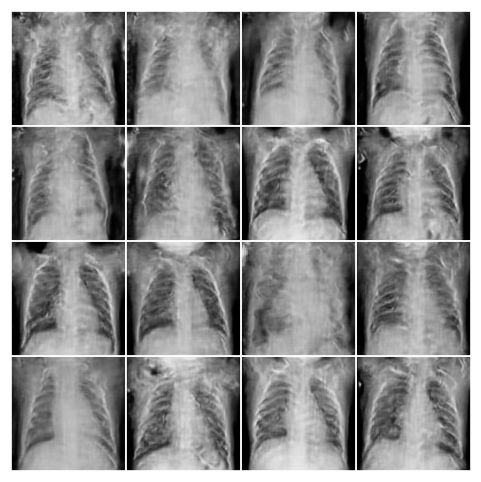

💾 Saved → ../Data/generated_samples/vaegan_batch.png


In [47]:
# ===============================================================
# 03_train_generator_part2.ipynb
# Sample brand-new images + show reconstructions
# ===============================================================

import os, math, numpy as np, torch
import matplotlib.pyplot as plt
from torchvision import utils as vutils

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 128
LATENT_DIM = 128

# ---- rebuild model definition (same as in Part 1) ----
# (Paste the ResBlock and ResVAE classes from Part 1 here)
# ------------------------------------------------------

vae = ResVAE(latent_dim=LATENT_DIM).to(DEVICE)
vae.load_state_dict(torch.load("../Model/vaegan_vae.pt", map_location=DEVICE))
vae.eval()
print("✅ Loaded VAE-GAN generator.")

os.makedirs("../Data/generated_samples", exist_ok=True)

@torch.no_grad()
def sample_grid(n=16):
    z = torch.randn(n, LATENT_DIM, device=DEVICE)
    xs = vae.decode(z).cpu()          # [-1,1]
    xs = (xs + 1)/2                   # [0,1]
    grid = vutils.make_grid(xs, nrow=int(math.sqrt(n)), pad_value=1.0)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.squeeze().permute(1,2,0), cmap="gray")
    plt.axis("off"); plt.show()
    vutils.save_image(xs, "../Data/generated_samples/vaegan_batch.png",
                      nrow=int(math.sqrt(n)))
    print("💾 Saved → ../Data/generated_samples/vaegan_batch.png")

sample_grid(16)